In [1]:
import torch
from torch import nn
from torch import optim

import pandas as pd
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
class CustomDataset(Dataset):

    def __init__(self, dataframe: pd.DataFrame, feature_names: list, target_name: str):
        scaler = StandardScaler()
        X = scaler.fit_transform(dataframe[feature_names])
        X = torch.tensor(X, dtype=torch.float32)
        
        self.X = X.reshape(X.shape[0], 1, X.shape[1])
        self.y = torch.tensor(dataframe[target_name].values, dtype=torch.float32)
        
    def __len__(self) -> int:
        return len(self.y)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [3]:
class DoubleConv(nn.Module):
    
    def __init__(self, in_size: int, out_size: int):
        super(DoubleConv, self).__init__()

        self.conv_net = nn.Sequential(
            nn.Conv1d(in_size, out_size, kernel_size=3, padding=1, stride=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_size, out_size, kernel_size=3, padding=1, stride=1, bias=False),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv_net(x)

In [4]:
class DownSample(nn.Module):

    def __init__(self, in_size: int, out_size: int):
        super(DownSample, self).__init__()

        self.conv = DoubleConv(in_size, out_size)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv(x)
        y = self.pool(x)
        return y, x

In [5]:
class UpSample(nn.Module):

    def __init__(self, in_size: int, out_size: int):
        super(UpSample, self).__init__()
        self.up = nn.ConvTranspose1d(in_size, out_size, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_size, out_size)

    def forward(self, x, y):
        x = self.up(x)
        u = torch.cat([x, y], dim=1)
        return self.conv(u)

In [6]:
class UNet(nn.Module):

    def __init__(self, in_size: int, num_classes: int):
        super(UNet, self).__init__()

        self.down_conv_1 = DownSample(in_size, 64)
        self.down_conv_2 = DownSample(64, 128)
        self.down_conv_3 = DownSample(128, 256)
        self.down_conv_4 = DownSample(256, 512)

        self.bottle_nack = DoubleConv(512, 1024)

        self.up_conv_1 = UpSample(1024, 512)
        self.up_conv_2 = UpSample(512, 256)
        self.up_conv_3 = UpSample(256, 128)
        self.up_conv_4 = UpSample(128, 64)

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*16, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):

        x, y1 = self.down_conv_1(x)
        x, y2 = self.down_conv_2(x)
        x, y3 = self.down_conv_3(x)
        x, y4 = self.down_conv_4(x)

        x = self.bottle_nack(x)

        x = self.up_conv_1(x, y4)
        x = self.up_conv_2(x, y3)
        x = self.up_conv_3(x, y2)
        x = self.up_conv_4(x, y1)

        out = self.fc(x)
        return out

In [7]:
df = pd.read_csv("data\df_01.csv", index_col=[0])
df = df.reset_index().drop(columns=['index'])

In [8]:
lithology_keys = {30000: 0,
                  65030: 1,
                  65000: 2,
                  80000: 3,
                  74000: 4,
                  70000: 5,
                  70032: 6,
                  88000: 7,
                  86000: 8,
                  99000: 9,
                  90000: 10,
                  93000: 11}

In [9]:
df['FORCE_2020_LITHOFACIES_LITHOLOGY'] = df['FORCE_2020_LITHOFACIES_LITHOLOGY'].map(lithology_keys)

In [10]:
encoder = OneHotEncoder(sparse_output=False)
one_hot_ecoded = encoder.fit_transform(df[['FORCE_2020_LITHOFACIES_LITHOLOGY']])
one_hot_df = pd.DataFrame(one_hot_ecoded, columns=encoder.get_feature_names_out())
df = pd.concat([df, one_hot_df], axis=1)

In [11]:
feature_names = ['DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'CALI', 'RMED', 'RDEP', 'RHOB',
                 'GR', 'NPHI', 'PEF', 'DTC', 'BS', 'DTS', 'DCAL', 'DRHO'] # 'ROP', 'ROPA'

target_name = ['FORCE_2020_LITHOFACIES_LITHOLOGY_0', 'FORCE_2020_LITHOFACIES_LITHOLOGY_1', 
               'FORCE_2020_LITHOFACIES_LITHOLOGY_2', 'FORCE_2020_LITHOFACIES_LITHOLOGY_3',
               'FORCE_2020_LITHOFACIES_LITHOLOGY_4', 'FORCE_2020_LITHOFACIES_LITHOLOGY_5',
               'FORCE_2020_LITHOFACIES_LITHOLOGY_6', 'FORCE_2020_LITHOFACIES_LITHOLOGY_7', 
               'FORCE_2020_LITHOFACIES_LITHOLOGY_8', 'FORCE_2020_LITHOFACIES_LITHOLOGY_9',
               'FORCE_2020_LITHOFACIES_LITHOLOGY_10']

In [12]:
dataset = CustomDataset(dataframe=df, feature_names=feature_names, target_name=target_name)

train_, test = data.random_split(dataset, [0.8, 0.2])
train, val = data.random_split(train_, [0.7, 0.3])

In [13]:
train_data = DataLoader(dataset=train, batch_size=64, shuffle=True)
val_data = DataLoader(dataset=val, batch_size=64, shuffle=True)
test_data = DataLoader(dataset=test, batch_size=64, shuffle=False)

In [14]:
model = UNet(1, len(target_name))


In [15]:
learning_rate = 0.01
batch_size = 64

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

model.train()

UNet(
  (down_conv_1): DownSample(
    (conv): DoubleConv(
      (conv_net): Sequential(
        (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (1): ReLU(inplace=True)
        (2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (3): ReLU(inplace=True)
      )
    )
    (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down_conv_2): DownSample(
    (conv): DoubleConv(
      (conv_net): Sequential(
        (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (1): ReLU(inplace=True)
        (2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (3): ReLU(inplace=True)
      )
    )
    (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down_conv_3): DownSample(
    (conv): DoubleConv(
      (conv_net): Sequential(
        (0): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padd

In [16]:
# epochs = 10

# for e in range(epochs):
#     loss_mean = 0
#     lm_count = 0

#     train_tqdm = tqdm(train_data, leave=True)
#     for x_train, y_train in train_tqdm:
#         predict = model(x_train)
#         loss = loss_function(predict, y_train)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         lm_count += 1
#         loss_mean = 1/lm_count * loss.item() + (1 - 1/lm_count) * loss_mean
#         train_tqdm.set_description(f'Epoch [{e+1}/{epochs}], loss_mean={loss_mean:.3f} ')

epochs = 5
best_loss = 1e10 # заведомо высокое значение
loss_val = []
loss_train = []

for e in range(epochs):
    model.train()
    loss_mean = 0
    lm_count = 0

    train_tqdm = tqdm(train_data, leave=False)
    for x_train, y_train in train_tqdm:
        predict = model(x_train)
        loss = loss_function(predict, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        lm_count += 1
        loss_mean = 1/lm_count * loss.item() + (1 - 1/lm_count) * loss_mean
        train_tqdm.set_description(f'Epoch [{e+1}/{epochs}], loss_mean={loss_mean:.3f} ')
    
    model.eval()
    Q_val = 0
    count_val = 0

    for x_val, y_val in val_data:
        with torch.no_grad():
            prediction = model(x_val)
            loss = loss_function(prediction, y_val)
            Q_val += loss.item()
            count_val += 1

    Q_val /= count_val

    loss_train.append(loss_mean)
    loss_val.append(Q_val)
    
    print(f' | loss_mean={loss_mean:.3f}, Q_val={Q_val:.3f}')



  0%|          | 0/1063 [00:00<?, ?it/s]

 | loss_mean=1.533, Q_val=1.482


 | loss_mean=1.492, Q_val=1.481


 | loss_mean=1.491, Q_val=1.483


 | loss_mean=1.490, Q_val=1.482


 | loss_mean=1.489, Q_val=1.480


In [17]:
Q = 0

In [18]:
model.eval()

UNet(
  (down_conv_1): DownSample(
    (conv): DoubleConv(
      (conv_net): Sequential(
        (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (1): ReLU(inplace=True)
        (2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (3): ReLU(inplace=True)
      )
    )
    (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down_conv_2): DownSample(
    (conv): DoubleConv(
      (conv_net): Sequential(
        (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (1): ReLU(inplace=True)
        (2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (3): ReLU(inplace=True)
      )
    )
    (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down_conv_3): DownSample(
    (conv): DoubleConv(
      (conv_net): Sequential(
        (0): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padd

In [19]:
predictions = []
tests = []
test_tqdm = tqdm(test_data, leave=True)
for x_test, y_test in test_tqdm:
    predict = model(x_test)
    predict = torch.argmax(predict, dim=1)
    y_test = torch.argmax(y_test, dim=1)
    predictions.extend(predict.cpu().detach().numpy().tolist())
    tests.extend(y_test.cpu().detach().numpy().tolist())
    Q += torch.sum(predict == y_test).item()

100%|██████████| 380/380 [02:02<00:00,  3.09it/s]


In [20]:
Q /= len(test_data)
print(Q)

36.28157894736842


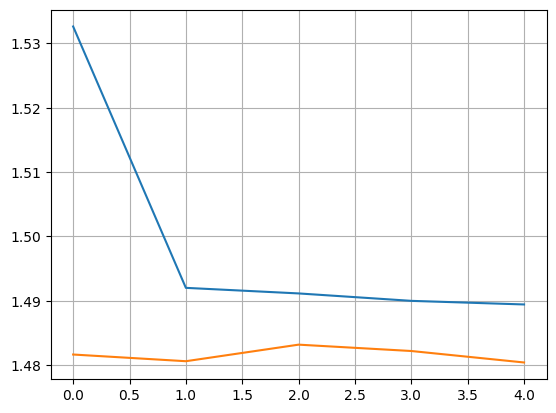

In [21]:
plt.plot(loss_train)
plt.plot(loss_val)
plt.grid()
plt.show()

In [22]:
from sklearn.metrics import confusion_matrix, classification_report

In [23]:
print(classification_report(tests, predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3063
           1       0.00      0.00      0.00      2135
           2       0.57      1.00      0.72     13787
           3       0.00      0.00      0.00      1019
           4       0.00      0.00      0.00        59
           5       0.00      0.00      0.00      1729
           6       0.00      0.00      0.00       580
           7       0.00      0.00      0.00      1271
           8       0.00      0.00      0.00       120
           9       0.00      0.00      0.00       477
          10       0.00      0.00      0.00        44

    accuracy                           0.57     24284
   macro avg       0.05      0.09      0.07     24284
weighted avg       0.32      0.57      0.41     24284



c:\Users\tatya\Documents\well_log\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\tatya\Documents\well_log\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\tatya\Documents\well_log\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Axes: >

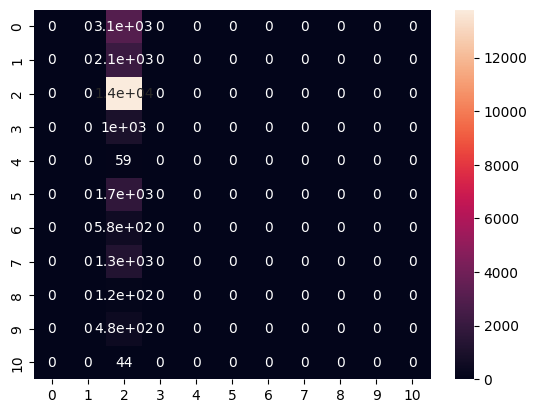

In [24]:
cm = confusion_matrix(tests, predictions)
sns.heatmap(cm, annot=True)